# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

Task: learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of DTP-DRL and L-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

## Learn $B = W^T$

We add tiny noise to the hidden layer in a network [1-2-1] and learn the backwards weights to align with $(W^\mathrm{PP})^T$.

In particular, to make it easiert to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})^T$ with positive values.

### Setup

In [2]:
# simulation settings

dt     = 1e-4 # in ms
dtxi   = 10 * dt
tausyn = 100 * dt
Tpres  = 1e+4 * dt
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 10 * Tpres # total simulation time

# noise settings: noise needs to be chosen very small, because we add it to the voltages,
# and then calculate the lookahead value. This leads to large values noise_breve, which is ultimately used to update BPP
noise_scale = [5*1e-7]

In [11]:
np.random.seed(1234)

# Init model: weights, voltages

layers = [1, 2, 1]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [200.0] * (len(layers) - 2)
eta_IP = [200.0] * (len(layers) - 1)
eta_PI = [50.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-1]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))

In [12]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(0, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

In [13]:
mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, 'LDRL', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

# mc1.set_self_predicting_state()

### Simulation

In [14]:
# # pre-training to settle voltages
# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [15]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
rPbreve_HI_time_series = []
xibreve_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    
    # uIbreve_time_series.append(copy.deepcopy(mc1.uI_breve))
    # uPbreve_time_series.append(copy.deepcopy(mc1.uP_breve))
    rIbreve_time_series.append(copy.deepcopy(mc1.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc1.rP_breve))
    u_time_series.append(copy.deepcopy(mc1.get_voltages()))

    rPbreve_HI_time_series.append(copy.deepcopy(mc1.rP_breve_HI))
    xibreve_time_series.append(copy.deepcopy(mc1.noise_breve))
    WPP, WIP, BPP, BPI = mc1.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
    
    dBPP_time_series.append(copy.deepcopy(mc1.dBPP))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1


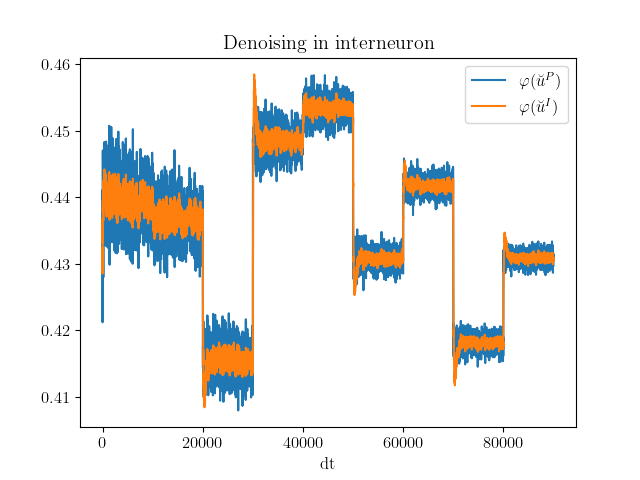

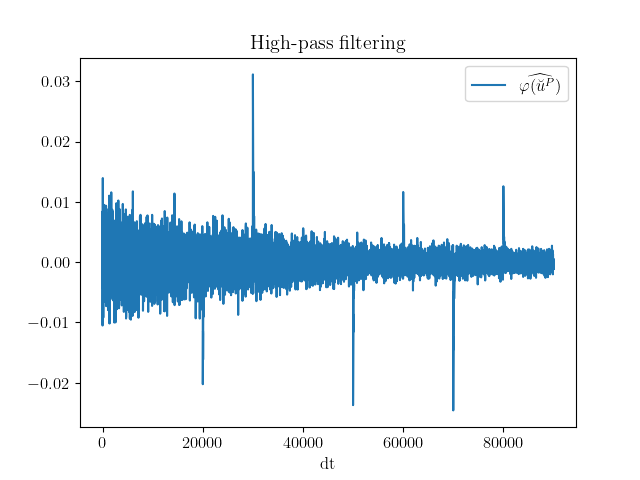

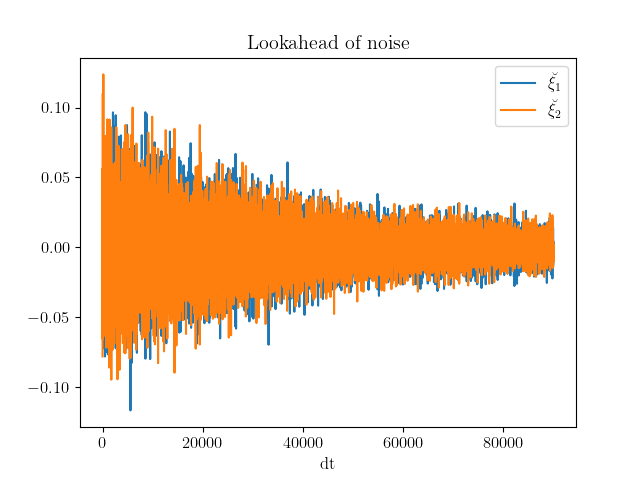

In [16]:
# fig = plt.figure()
# rP = [rP[0] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.show()

fig = plt.figure()
rP = [rP[1] for rP in rPbreve_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
plt.legend()
plt.title("Denoising in interneuron")
plt.xlabel('dt')
plt.show()


fig = plt.figure()
rPbreve_HI = [rPbreve_HI[1] for rPbreve_HI in rPbreve_HI_time_series]
plt.plot(np.array(rPbreve_HI[int(Tpres/dt):]).ravel(), label="$\widehat{\\varphi{(\\breve{u}^P)}}$")
plt.xlabel('dt')
plt.title("High-pass filtering")
plt.legend()
plt.show()

fig = plt.figure()
xibreve = [xibreve[0] for xibreve in xibreve_time_series]
plt.plot(np.array(xibreve[int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
plt.title("Lookahead of noise")
plt.xlabel('dt')
plt.legend()
plt.show()

Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [17]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 1)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 1)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 1)
                           ]))

BPP at init:

In [18]:
BPP_time_series[0][0]

array([[-0.64107033],
       [-0.49849892]])

BPP after learning, rescaled:

In [19]:
BPP_time_series[-1][0] * 1.25e+5

array([[0.27404539],
       [0.59214688]])

WPP^T (fixed):

In [20]:
WPP_time_series[0][1].T

array([[0.27646426],
       [0.80187218]])

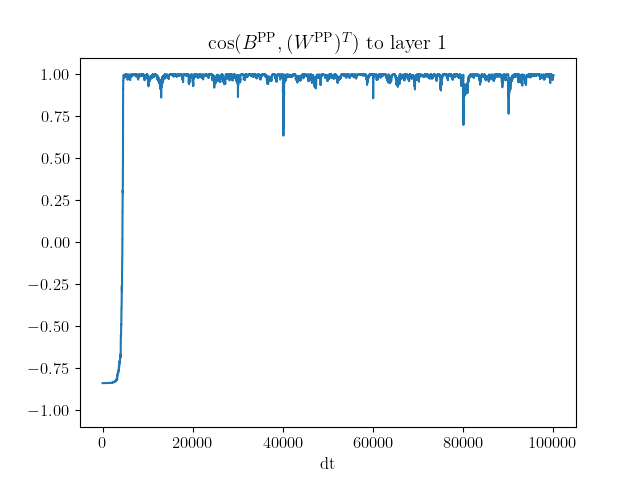

In [21]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

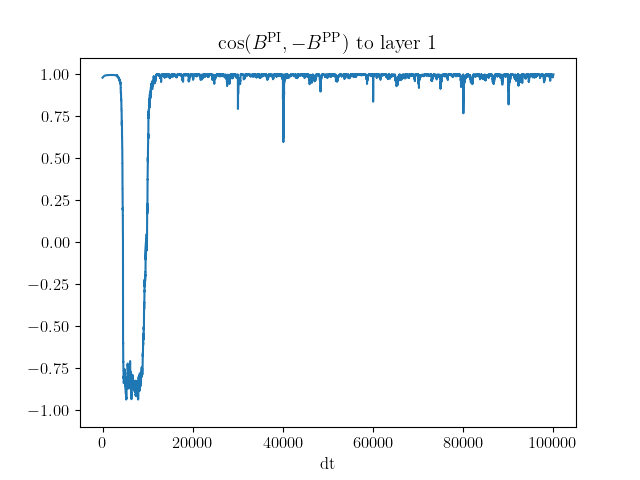

In [22]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array(BPI_time_series).ravel(), label="BPI")
# ax.plot(-np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

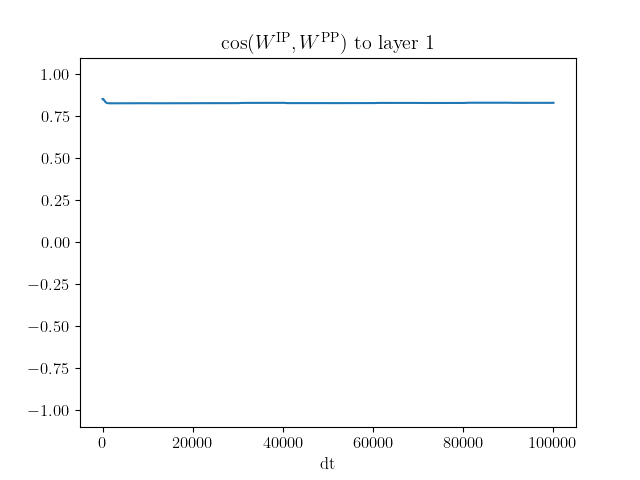

In [23]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

## Learn $B = W^T$

We make another example with a network of size [1-2-2].

### Setup

In [53]:
# simulation settings

dt     = 1e-4 # in ms
dtxi   = 10 * dt
tausyn = 100 * dt
Tpres  = 1e+4 * dt
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 100 * Tpres # total simulation time

# noise settings: noise needs to be chosen very small, because we add it to the voltages,
# and then calculate the lookahead value. This leads to large values noise_breve, which is ultimately used to update BPP
noise_scale = [1e-6]

In [54]:
np.random.seed(12345)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [10.0] * (len(layers) - 2)
eta_IP = [20.0] * (len(layers) - 1)
eta_PI = [100.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [1e-1]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    

INIT_CONST = 2
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i+1], layers[i])))

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i], layers[-1])))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-INIT_CONST, INIT_CONST, size=(layers[i], layers[-1])))

In [55]:
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(-1, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

In [56]:
mc2 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, 'LDRL', logistic, d_logistic, layers,
            uP_init=uP_init, uI_init=uI_init,
            WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
            gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
            eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc2.set_self_predicting_state()

### Simulation

In [57]:
u_time_series = []
uIbreve_time_series = []
uPbreve_time_series = []
rIbreve_time_series = []
rPbreve_time_series = []
rPbreve_HI_time_series = []
xibreve_time_series = []
vapi_time_series = []

WPP_time_series = []
BPP_time_series = []
WIP_time_series = []
BPI_time_series = []
dBPP_time_series = []

for i in range(len(r0_random)):
    mc2.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    
    rIbreve_time_series.append(copy.deepcopy(mc2.rI_breve))
    rPbreve_time_series.append(copy.deepcopy(mc2.rP_breve))
    u_time_series.append(copy.deepcopy(mc2.get_voltages()))
    vapi_time_series.append(copy.deepcopy(mc2.vapi))

    rPbreve_HI_time_series.append(copy.deepcopy(mc2.rP_breve_HI))
    xibreve_time_series.append(copy.deepcopy(mc2.noise_breve))
    WPP, WIP, BPP, BPI = mc2.get_weights()
    WPP_time_series.append(copy.deepcopy(WPP))
    BPP_time_series.append(copy.deepcopy(BPP))
    WIP_time_series.append(copy.deepcopy(WIP))
    BPI_time_series.append(copy.deepcopy(BPI))
        
uP_time_series = [u[0] for u in u_time_series]
uI_time_series = [u[1] for u in u_time_series]

Current time: 0s
Learning backward weights to layer 1
Current time: 1.0s
Learning backward weights to layer 1
Current time: 2.0s
Learning backward weights to layer 1
Current time: 3.0s
Learning backward weights to layer 1
Current time: 4.0s
Learning backward weights to layer 1
Current time: 5.0s
Learning backward weights to layer 1
Current time: 6.0s
Learning backward weights to layer 1
Current time: 7.0s
Learning backward weights to layer 1
Current time: 8.0s
Learning backward weights to layer 1
Current time: 9.0s
Learning backward weights to layer 1
Current time: 10.0s
Learning backward weights to layer 1
Current time: 11.0s
Learning backward weights to layer 1
Current time: 12.0s
Learning backward weights to layer 1
Current time: 13.0s
Learning backward weights to layer 1
Current time: 14.0s
Learning backward weights to layer 1
Current time: 15.0s
Learning backward weights to layer 1
Current time: 16.0s
Learning backward weights to layer 1
Current time: 17.0s
Learning backward weigh

/Users/km/Software/anaconda3/lib/python3.8/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


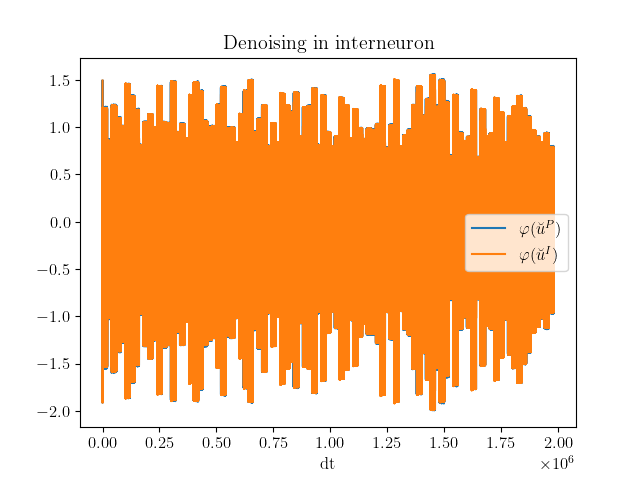

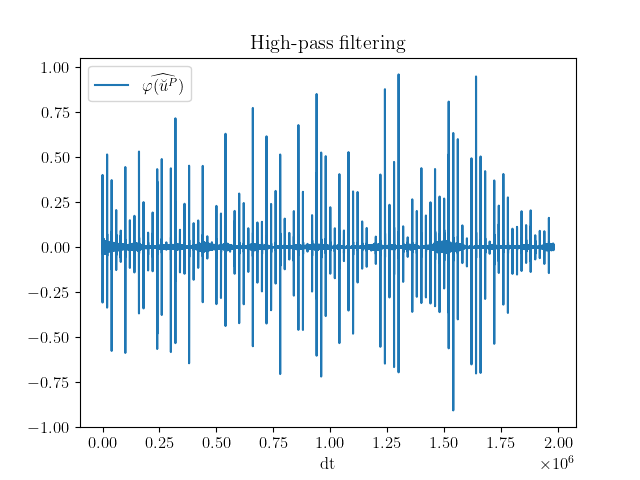

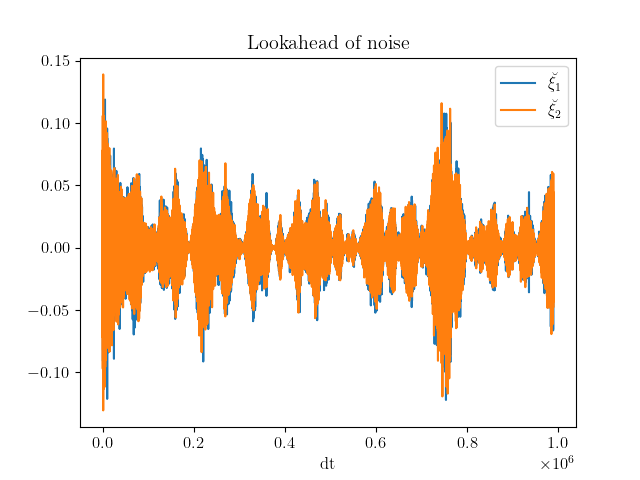

In [82]:
# fig = plt.figure()
# rP = [rP[0] for rP in rPbreve_time_series]
# plt.plot(np.array(rP[int(Tpres/dt):]).ravel())
# plt.show()

fig = plt.figure()
rP = [rP[1] for rP in rPbreve_time_series]
plt.plot(np.array(rP[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^P)}$")
plt.plot(np.array(rIbreve_time_series[int(Tpres/dt):]).ravel(), label="$\\varphi{(\\breve{u}^I)}$")
plt.legend()
plt.title("Denoising in interneuron")
plt.xlabel('dt')
plt.show()


fig = plt.figure()
rPbreve_HI = [rPbreve_HI[1] for rPbreve_HI in rPbreve_HI_time_series]
plt.plot(np.array(rPbreve_HI[int(Tpres/dt):]).ravel(), label="$\widehat{\\varphi{(\\breve{u}^P)}}$")
plt.xlabel('dt')
plt.title("High-pass filtering")
plt.legend()
plt.show()

fig = plt.figure()
xibreve = [xibreve[0] for xibreve in xibreve_time_series]
plt.plot(np.array(xibreve[int(Tpres/dt):]), label=["$\\breve{\\xi_1}$","$\\breve{\\xi_2}$"])
plt.title("Lookahead of noise")
plt.xlabel('dt')
plt.legend()
plt.show()

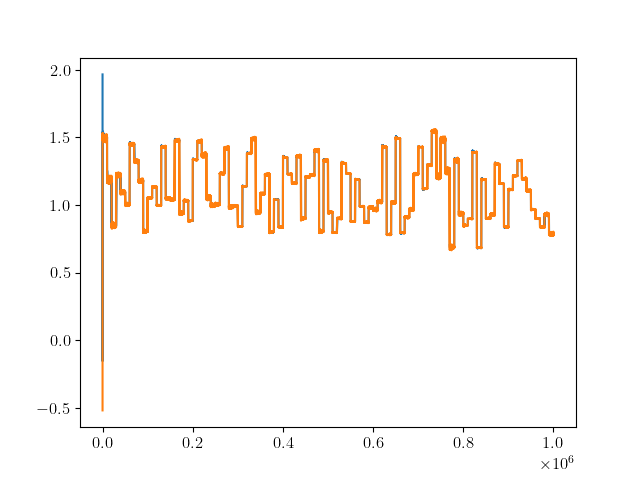

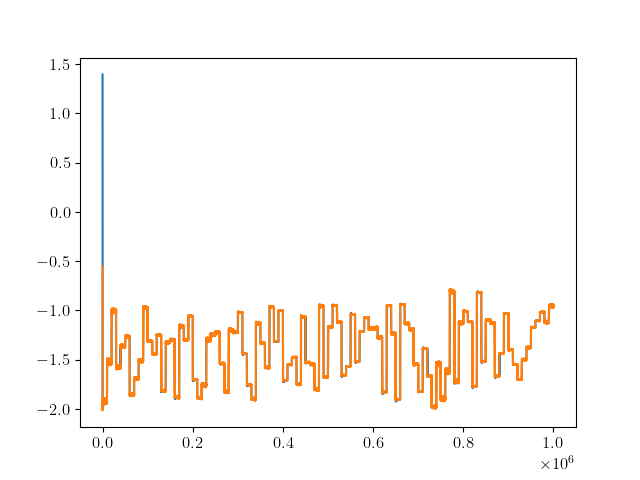

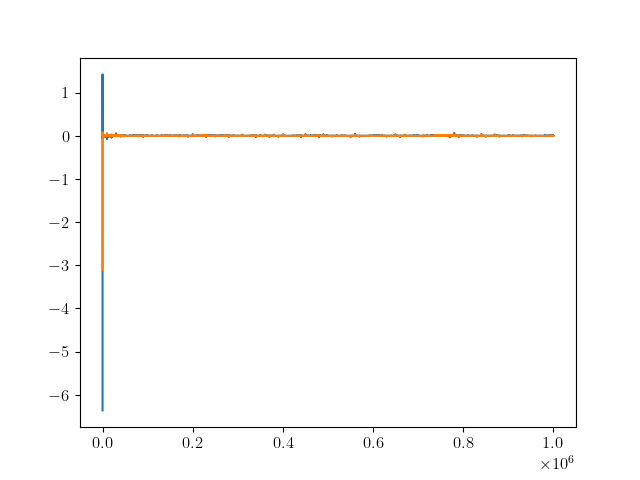

In [71]:
for i in range(layers[-1]):
    
    # plot neuron outputs in output layer

    fig = plt.figure()
    plt.plot(np.array(rIbreve_time_series).T[i][0])
    plt.plot(np.array(rPbreve_time_series).T[i][1])
    plt.show()
    
# check apical potentials

fig = plt.figure()
plt.plot(np.array(vapi_time_series).T[0][0])
plt.plot(np.array(vapi_time_series).T[1][0])
plt.show()


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [72]:
cos_BPI_BPP = []
for i in range(len(BPI_time_series[0])):
    cos_BPI_BPP.append(np.array([
        cos_sim(BPI_time_series[j][i], -BPP_time_series[j][i]) for j in range(0, len(BPI_time_series), 10)
                           ]))
    
cos_WIP_WPP = []
for i in range(len(WIP_time_series[0])):
    cos_WIP_WPP.append(np.array([
        cos_sim(WIP_time_series[j][i], WPP_time_series[j][i+1]) for j in range(0, len(WIP_time_series), 10)
                           ]))
    
cos_WPPtrans_BPP = []
for i in range(len(BPP_time_series[0])):
    cos_WPPtrans_BPP.append(np.array([
        cos_sim(BPP_time_series[j][i], WPP_time_series[j][i+1].T) for j in range(0, len(BPP_time_series), 10)
                           ]))

BPP at init:

In [73]:
BPP_time_series[0][0]

array([[1.85839252, 0.89463906],
       [0.56986707, 0.86975184]])

BPP after learning, rescaled:

In [74]:
BPP_time_series[-1][0]

array([[ 2.03681225e-05, -4.27229413e-05],
       [ 4.73476864e-05, -4.18219164e-05]])

WPP^T (fixed):

In [75]:
WPP_time_series[0][1].T

array([[ 0.99085924, -1.96644681],
       [ 1.84522694, -1.57422249]])

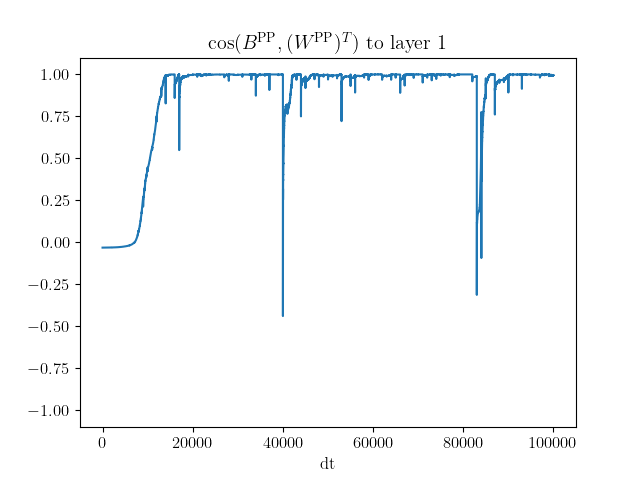

In [76]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WPPtrans_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^T)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1].T for WPP in WPP_time_series]).ravel(), label="WPP.T")
# ax.plot(np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

In [77]:
BPI_time_series[0]

[array([[-1.73350821, -0.80607929],
        [-0.50873179, -0.82645564]])]

In [78]:
-BPI_time_series[-1][0]

array([[1.450066  , 1.19577521],
       [0.69237636, 0.57090575]])

In [79]:
BPP_time_series[-1]

[array([[ 2.03681225e-05, -4.27229413e-05],
        [ 4.73476864e-05, -4.18219164e-05]])]

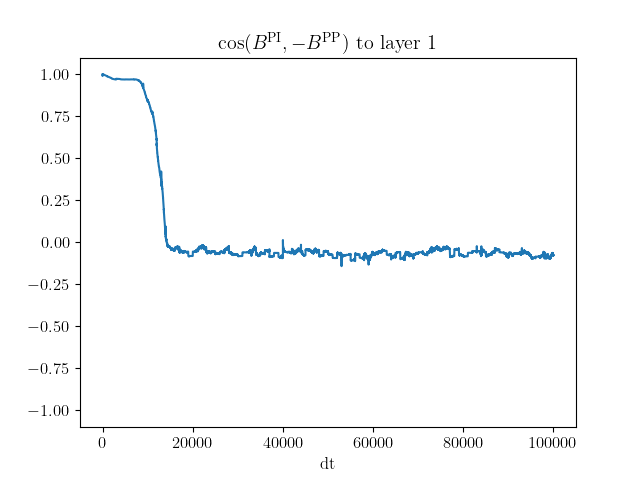

In [80]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_BPI_BPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    

# fig, ax = plt.subplots()
# ax.plot(np.array(BPI_time_series).ravel(), label="BPI")
# ax.plot(-np.array(BPP_time_series).ravel(), label="BPP")
# plt.yscale('linear')
# label = 'dt'
# plt.xlabel(label)
# plt.ylabel("B")
# plt.legend()
# # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
# plt.show()

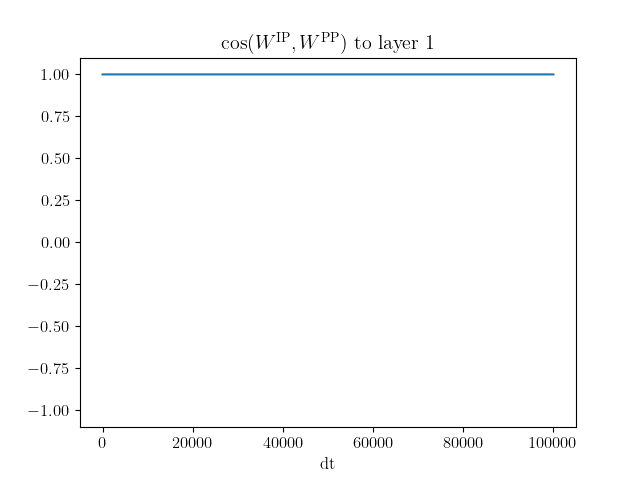

In [81]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(cos_WIP_WPP[i])
    plt.yscale('linear')
    label = 'dt'
    plt.xlabel(label)
    plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()